In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
from scipy import sparse
import copy

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils.extmath import randomized_svd

import matplotlib.pyplot as plt 

%matplotlib inline


#### Loading datasets

In [2]:
class GraphDataset:
    def __init__(self, folder_path=''):

        G = nx.Graph()
        data_adj = np.loadtxt(folder_path + '_A.txt', delimiter=',').astype(int)
        data_graph_indicator = np.loadtxt(folder_path + '_graph_indicator.txt', delimiter=',').astype(int)
        labels = np.loadtxt(folder_path + '_graph_labels.txt', delimiter=',').astype(int)

        data_tuple = list(map(tuple, data_adj))
        G.add_edges_from(data_tuple)
        G.remove_nodes_from(list(nx.isolates(G)))

        # split into graphs

        le = LabelEncoder()
        self.labels_ = le.fit_transform(labels)
        self.n_classes_ = len(le.classes_)
        self.n_graphs_ = len(self.labels_)

        graph_num = data_graph_indicator.max()
        node_list = np.arange(data_graph_indicator.shape[0]) + 1
        self.graphs_ = []

        for i in range(graph_num):

            nodes = node_list[data_graph_indicator == i + 1]
            G_sub = G.subgraph(nodes).copy()
            
            max_cc = max(nx.connected_components(G_sub), key=len)
            G_sub = G_sub.subgraph(max_cc).copy()
            G_sub.graph['label'] = self.labels_ [i]
            nx.convert_node_labels_to_integers(G_sub)
            self.graphs_.append(G_sub)     

        self.graphs_ = np.array(self.graphs_)

        print('Loaded')

Only two datasets are given with the code in the supplementary material. All other datasets can be downloaded here: https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets.

In [3]:
graphs_name = ['MUTAG', 'ENZYMES', 'PROTEINS_full', 'DD', 'NCI1']
data_pwd = 'Data/'

In [4]:
datasets = {}
for gn in graphs_name:
    print(gn)
    datasets[gn] = GraphDataset(folder_path=data_pwd + gn + '/' + gn)

MUTAG
Loaded
ENZYMES
Loaded
PROTEINS_full
Loaded
DD
Loaded
NCI1
Loaded


### Truncated Laplacian Spectrum as Graph Feature Representation

In [5]:
def padded_spectral(graph, embedding_dimension=16, normalized=False):
    
    # Padding with zeros (if necessary)
    embedding = np.zeros(embedding_dimension)

    # Usage of networkx graph objects
    adj_matrix = nx.adj_matrix(graph)
    n_nodes = nx.number_of_nodes(graph)
    k = min(embedding_dimension, n_nodes - 1)

    if normalized:
        laplacian = nx.normalized_laplacian_matrix(graph)
    else:
        laplacian = nx.laplacian_matrix(graph).astype(float)
        
    try:
        eigenvalues = randomized_svd(laplacian, k)[1]
    except:
        eigenvalues = sp.sparse.linalg.svds(laplacian, k=k, return_singular_vectors=False)
    if len(eigenvalues)>1:
        embedding[-k:] = sorted(eigenvalues)
    return embedding

In [6]:
def dataset_embedding(dataset, embedding_dim, normalized=False):

    list_graphs = []
    for g in dataset.graphs_:
        x = padded_spectral(g, embedding_dim, normalized)
        y = g.graph['label']

        list_graphs.append((x, y))

    X = np.array([l[0] for l in list_graphs])
    labels = np.array([l[1] for l in list_graphs])
    
    return X, labels

#### Embedding dimension is set to the percentile 95 of the distribution of graph sizes in each datase

In [7]:
embedding_dims = {'MUTAG': 0, 'ENZYMES': 0, 'PROTEINS_full': 0, 'DD': 0, 'NCI1': 0}
for e in datasets:
    embedding_dims[e] = int(np.percentile([nx.number_of_nodes(g) for g in datasets[e].graphs_], q=95))

In [8]:
embedding_dims

{'MUTAG': 25, 'ENZYMES': 52, 'PROTEINS_full': 105, 'DD': 585, 'NCI1': 58}

#### TLS extraction for all graphs of all datasets

In [9]:
%%time

embedded_datasets = {}

for name, dataset in datasets.items():
    X, y = dataset_embedding(dataset, embedding_dims[name])
    embedded_datasets[name] = {'X': X, 'y': y}

CPU times: user 2min 18s, sys: 294 ms, total: 2min 18s
Wall time: 4min 58s


### Experiments presented in the paper

#### Results for Erdos random graphs

We chose parameter p=0.05 for the graph generation.

Text(0.5, 0, 'Number of edge additions')

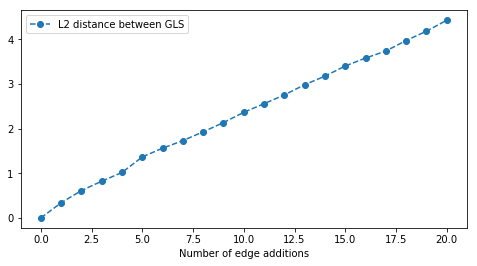

In [10]:
norm_E = [0]
graph = nx.erdos_renyi_graph(100, 0.05)
graph_ = graph.copy()
E = np.zeros((graph_.number_of_nodes(), graph_.number_of_nodes()))
embedding_dimension=len(graph_)
list_embedding = [np.expand_dims(padded_spectral(graph_, embedding_dimension), 0)]

for i in range(20):
    [u, v] = random.sample(graph_.nodes(), 2)
    while (u, v) in graph_.edges():
        [u, v] = random.sample(graph_.nodes(), 2)
    graph_.add_edge(u, v)
    E[u, v] += 1
    E[v, u] += 1
    norm_E.append(np.sum(np.absolute(E)))
    list_embedding.append(np.expand_dims(padded_spectral(graph_, embedding_dimension), 0))
    
embeddings = np.concatenate(list_embedding, axis=0)
embeddings = (embeddings - embeddings[0])**2

plt.figure(figsize=(8, 4))
plt.plot(np.sqrt(embeddings.sum(1)), label='L2 distance between GLS', linestyle='dashed', marker='o');
# plt.plot(norm_E, label='Norm 1 of E');
plt.legend()
plt.xlabel('Number of edge additions')

Text(0.5, 0, 'Number of edge withdrawals')

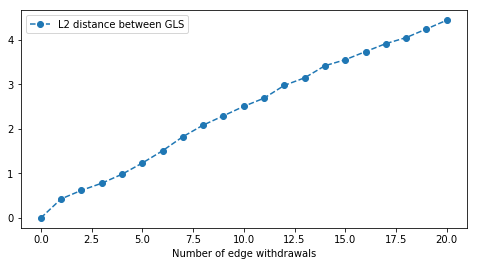

In [11]:
norm_E = [0]
graph = nx.erdos_renyi_graph(100, 0.05)
graph_ = graph.copy()
E = np.zeros((graph_.number_of_nodes(), graph_.number_of_nodes()))
embedding_dimension=len(graph_)
list_embedding = [np.expand_dims(padded_spectral(graph_, embedding_dimension), 0)]

for i in range(20):
    [(u, v)] = random.sample(graph_.edges(), 1)
    graph_.remove_edge(u, v)
    E[u, v] -= 1
    E[v, u] -= 1
    norm_E.append(np.sum(np.absolute(E)))
    list_embedding.append(np.expand_dims(padded_spectral(graph_, embedding_dimension), 0))

embeddings = np.concatenate(list_embedding, axis=0)
embeddings = np.absolute(embeddings - embeddings[0])**2

plt.figure(figsize=(8,4))
plt.plot(np.sqrt(embeddings.sum(1)), label='L2 distance between GLS', linestyle='dashed', marker='o');
# plt.plot(norm_E, label='Norm 1 of E');
plt.legend()
plt.xlabel('Number of edge withdrawals')

Text(0, 0.5, 'L2 distance between TLS')

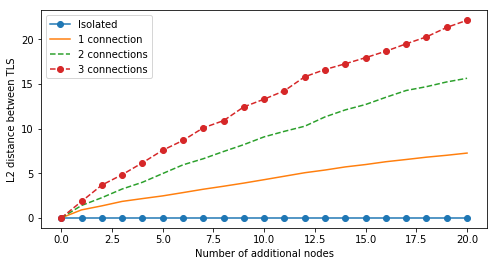

In [12]:
graph_ = nx.erdos_renyi_graph(28, 0.05)
m = max(list(graph_.nodes()))

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_0 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(graph.nodes(), 1)
    graph.add_node(m + j)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_0.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_0 = np.concatenate(list_embedding_aligned_0, axis=0)
embeddings_aligned_0 = (embeddings_aligned_0 - embeddings_aligned_0[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_1 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(graph.nodes(), 1)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_1.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_1 = np.concatenate(list_embedding_aligned_1, axis=0)
embeddings_aligned_1 = (embeddings_aligned_1 - embeddings_aligned_1[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_2 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n, m] = random.sample(graph.nodes(), 2)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_2.append(np.expand_dims(SF[-embedding_dimension:], 0))
    
embeddings_aligned_2 = np.concatenate(list_embedding_aligned_2, axis=0)
embeddings_aligned_2 = (embeddings_aligned_2 - embeddings_aligned_2[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_3 = [np.expand_dims(nx.laplacian_spectrum(graph), 0)]

for j in range(1, 21):
    [n, m, l] = random.sample(graph.nodes(), 3)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    graph.add_edge(m + j, l)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_3.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_3 = np.concatenate(list_embedding_aligned_3, axis=0)
embeddings_aligned_3 = (embeddings_aligned_3 - embeddings_aligned_3[0])**2

plt.figure(figsize=(8,4))
plt.plot(np.sqrt(embeddings_aligned_0.sum(1)), label='Isolated', marker='o');
plt.plot(np.sqrt(embeddings_aligned_1.sum(1)), label='1 connection');
plt.plot(np.sqrt(embeddings_aligned_2.sum(1)), label='2 connections', linestyle='dashed');
plt.plot(np.sqrt(embeddings_aligned_3.sum(1)), label='3 connections', linestyle='dashed', marker='o');
plt.legend()
plt.xlabel('Number of additional nodes')
plt.ylabel('L2 distance between TLS')

Text(0, 0.5, 'Rescaled L2 distance between TLS')

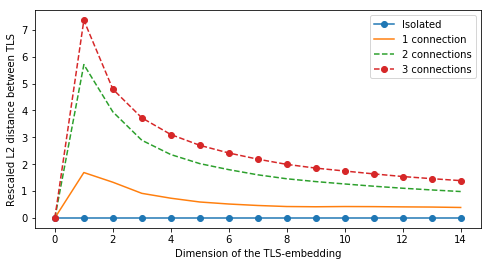

In [13]:
plt.figure(figsize=(8,4))
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_0[0][:,-j:] - list_embedding_aligned_0[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='Isolated', marker='o')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_1[0][:,-j:] - list_embedding_aligned_1[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='1 connection')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_2[0][:,-j:] - list_embedding_aligned_2[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='2 connections', linestyle='dashed')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_3[0][:,-j:] - list_embedding_aligned_3[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='3 connections', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Dimension of the TLS-embedding')
plt.ylabel('Rescaled L2 distance between TLS')

#### Reults for real molecular graphs

We chose the largest graph of PTC_MR as illustrative example.

In [14]:
name = 'MUTAG'
n_, i_ = 0, 0
for i, g in enumerate(datasets[name].graphs_):
    n_ = max(g.number_of_nodes(), n_)
    if g.number_of_nodes()==n_:
        i_ = i
        
print(n_)
print(len(datasets[name].graphs_))

28
188


In [15]:
graph = datasets[name].graphs_[i_].copy()
SF = padded_spectral(graph, embedding_dims[name], normalized=False)
dist_to_larger = []

for g in datasets[name].graphs_:
    dist_to_larger.append(np.sqrt(((SF-padded_spectral(g, embedding_dims[name], normalized=False))**2).sum()))

In [16]:
percentiles = [np.percentile(dist_to_larger, q=i) for i in range(25, 101, 25)]

Text(0, 0.5, 'L2 distance between TLS')

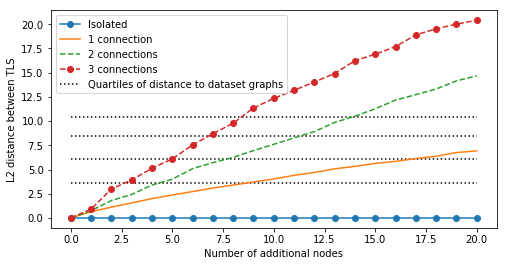

In [17]:
graph_ = datasets[name].graphs_[10].copy()
m = max(list(graph_.nodes()))

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_0 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(graph.nodes(), 1)
    graph.add_node(m + j)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_0.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_0 = np.concatenate(list_embedding_aligned_0, axis=0)
embeddings_aligned_0 = (embeddings_aligned_0 - embeddings_aligned_0[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_1 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(graph.nodes(), 1)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_1.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_1 = np.concatenate(list_embedding_aligned_1, axis=0)
embeddings_aligned_1 = (embeddings_aligned_1 - embeddings_aligned_1[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_2 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n, m] = random.sample(graph.nodes(), 2)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_2.append(np.expand_dims(SF[-embedding_dimension:], 0))
    
embeddings_aligned_2 = np.concatenate(list_embedding_aligned_2, axis=0)
embeddings_aligned_2 = (embeddings_aligned_2 - embeddings_aligned_2[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_3 = [np.expand_dims(nx.laplacian_spectrum(graph), 0)]

for j in range(1, 21):
    [n, m, l] = random.sample(graph.nodes(), 3)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    graph.add_edge(m + j, l)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_3.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_3 = np.concatenate(list_embedding_aligned_3, axis=0)
embeddings_aligned_3 = (embeddings_aligned_3 - embeddings_aligned_3[0])**2

plt.figure(figsize=(8,4))
plt.plot(np.sqrt(embeddings_aligned_0.sum(1)), label='Isolated', marker='o');
plt.plot(np.sqrt(embeddings_aligned_1.sum(1)), label='1 connection');
plt.plot(np.sqrt(embeddings_aligned_2.sum(1)), label='2 connections', linestyle='dashed');
plt.plot(np.sqrt(embeddings_aligned_3.sum(1)), label='3 connections', linestyle='dashed', marker='o');
plt.hlines(percentiles, xmin=0, xmax=20, linestyle='dotted', label='Quartiles of distance to dataset graphs');
plt.legend()
plt.xlabel('Number of additional nodes')
plt.ylabel('L2 distance between TLS')

Text(0, 0.5, 'Rescaled L2 distance between TLS')

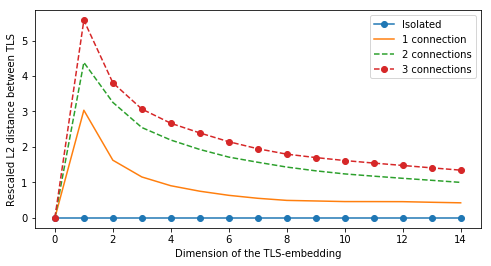

In [18]:
plt.figure(figsize=(8,4))
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_0[0][:,-j:] - list_embedding_aligned_0[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='Isolated', marker='o')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_1[0][:,-j:] - list_embedding_aligned_1[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='1 connection')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_2[0][:,-j:] - list_embedding_aligned_2[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='2 connections', linestyle='dashed')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_3[0][:,-j:] - list_embedding_aligned_3[-1][:,-j:])**2))/j 
          for j in range(1, 15)], label='3 connections', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Dimension of the TLS-embedding')
plt.ylabel('Rescaled L2 distance between TLS')

#### Classification results with SVM

In [26]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.svm import SVC
from operator import itemgetter

p_grid = {"C": [0.5, 1, 5], "gamma": [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5]}

scores = {}

for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    skf.get_n_splits(X, y)
    
    svm = SVC(kernel="rbf")
    scores[name] = []
    
    for train_index, test_index in skf.split(X, y):
        X_train = itemgetter(*train_index)(X)
        X_test = itemgetter(*test_index)(X)
        y_train = itemgetter(*train_index)(y)
        y_test = itemgetter(*test_index)(y)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=0)
        
        clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, iid=False, n_jobs=-1)
        clf.fit(X_train, y_train)
        
        scores[name].append((clf.predict(X_test) == y_test).astype(float).mean())
        
    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}, Std: {:2f}'.format(name,
                                                                   X.shape[1],
                                                                   np.mean(scores[name]),
                                                                   np.std(scores[name])))

Dataset: MUTAG, Embedding dim: 25, Accuracy: 0.878977, Std: 0.070240
Dataset: ENZYMES, Embedding dim: 52, Accuracy: 0.406667, Std: 0.062893
Dataset: PROTEINS_full, Embedding dim: 105, Accuracy: 0.752872, Std: 0.034547
Dataset: DD, Embedding dim: 585, Accuracy: 0.744513, Std: 0.032746
Dataset: NCI1, Embedding dim: 58, Accuracy: 0.732835, Std: 0.020819


#### Impact of truncation

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from operator import itemgetter

p_grid = {"C": [0.5, 1, 5], "gamma": [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5]}

scores, all_scores = {}, {}

for name in embedded_datasets:

    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    
    svm = SVC(kernel="rbf")
    scores[name] = []
    all_scores[name] = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    for i in range(0, X.shape[1], np.round(X.shape[1] / 5, 0).astype(int)):
        cv = KFold(n_splits=5, shuffle=True, random_state=0)

        clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, iid=False, n_jobs=-1)
        clf.fit(X_train[:, i:], y_train)

        scores[name].append((clf.predict(X_test[:, i:]) == y_test).astype(float).mean())
            
        all_scores[name].append(np.mean(scores[name]))

Text(0, 0.5, 'Relative performance')

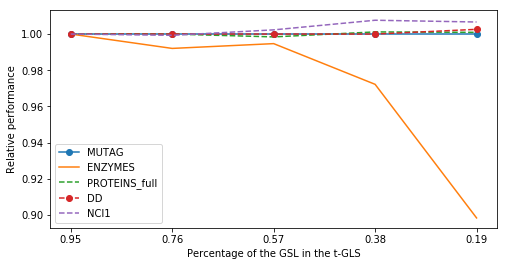

In [25]:
plt.figure(figsize=(8,4))

plt.plot(np.array(all_scores['MUTAG'][:5]) / all_scores['MUTAG'][0], label='MUTAG', marker='o')
plt.plot(np.array(all_scores['ENZYMES'][:5]) / all_scores['ENZYMES'][0], label='ENZYMES')
plt.plot(np.array(all_scores['PROTEINS_full'][:5]) / all_scores['PROTEINS_full'][0], label='PROTEINS_full', linestyle='dashed')
plt.plot(np.array(all_scores['DD'][:5]) / all_scores['DD'][0], label='DD', linestyle='dashed', marker='o')
plt.plot(np.array(all_scores['NCI1'][:5]) / all_scores['NCI1'][0], label='NCI1', linestyle='dashed')

plt.xticks(ticks=np.arange(5), labels=np.arange(1, 6)[::-1]*0.95/5)
plt.legend()
plt.xlabel('Percentage of the GSL in the t-GLS')
plt.ylabel('Relative performance')